# <center> Идентификация пользователей по посещенным веб-страницам

В этом проекте решалась задача идентификации пользователя по его поведению в сети Интернет. По последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, требовалось идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

Не все операции можно выполнить за разумное время, поэтому мы будем использовалось параллельно 2 выборки: по 10 пользователям и по 150. Для 10 пользователей отлаживали код, а для 150 – рабочая версия.

Имеются данные с прокси-серверов Университета Блеза Паскаля, они имеют очень простой вид. Для каждого пользователя заведен csv-файл с названием user\*\*\*\*.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате: <br>

<center>*timestamp, посещенный веб-сайт*</center>


Для предобработки данных, создадим словарь с частотами сайтов во всей выборке и индексами и для каждого пользователя разобьём csv файла на сессии длиной в 10 сайтов. Далее преобразуем полученные последовательности сессий пользователей в матрицу, где в первых 10 столбцах будут индексы посещенных пользователем сайтов и еще один столбец - ID пользователя. Индексы сайтов не удобно использовать в таком виде, намного удобнее использовать идею мешка слова из обработки текстов, для этого преобразуем матрицу в другую матрицу где столбцы будут означать индексы сайтов, строки - сессии пользователей, а в ячейках находится количество посещений сайта с данным индексом в данной сессии. Поскольку в матрице присутствует много нулей, еще удобнее работать с разреженными матрицами scikit-learn – csr_matrix.

__Простой пример кода позволяющий произвести вышеописанные преобразования:__

In [ ]:
def prepare_train_set(path_to_csv_files, session_length=10):
    '''
    Преобразует из файлов с каждой строкой в формате "timestamp, посещенный веб-сайт" 
        матрицу с длиной сессии session_length.
    
    :param path_to_csv_files - путь к папке с файлами, каждое название файла в формате "user****.csv", 
        где **** - ID пользователя.
    :param session_length - длина одной сессии пользователя
    
    :returns pandas.DataFrame - матрица сессий и dict - словарь сайтов, индексы - названия сайтов, 
        значения - tuple(индекс сайта, частота сайта в выборке)
    '''
    freq_dict = {}
    files = sorted(glob(os.path.join(path_to_csv_files, '*.csv')))
    for file in files:
        dft = pd.read_csv(file) 
        for site in dft.site:
            if site in freq_dict:
                freq_dict[site] += 1
            else:
                freq_dict[site] = 1
                
    for index, item in enumerate(sorted(freq_dict.items(), key = lambda x: x[1], reverse = True), start = 1):
        freq_dict[item[0]] = (index, item[1])
        
    ls = []    
    for file in tqdm_notebook(files, "file#"):
        ind = int(os.path.basename(file)[4:8])
        dft = pd.read_csv(file) 
        split_bounds = [i for i in range(dft.shape[0]) if not (i % session_length)]
        for sites in tqdm_notebook(np.split(dft.site, split_bounds)):
            if not len(sites):
                continue
            vals = list(map(lambda x: freq_dict[x][0], sites))
            ls.append(vals + [0] * (session_length - len(vals)) + [ind])
            
    df = pd.DataFrame(ls, columns = ["site%d" % (i+1) for i in range(session_length)] + ['user_id'])
    
    return df, freq_dict

In [ ]:
from collections import Counter

def tosparse(x):
    '''
    Преобразует numpy массив с индексами сайтов к разряженному виду частот сайтов в стоке.
    '''
    data = []
    colind = []
    rowind = []

    for ind, row in tqdm_notebook(enumerate(x)):
        cd = Counter(row)
        for k, v in cd.items():
            colind.append(k)
            data.append(v)
            rowind.append(ind)
    return csr_matrix((data, (rowind, colind)))[:, 1:]#частота 0 нам не нужна

Поскольку длина сессии - гиперпараметр, то следаем еще несколько матриц с разной длиной сессии и шириной окна (метод скользящего окна).

**Пример**: для длины сессии 10 и ширины окна 7 файл из 30 записей породит не 3 сессии, как раньше (1-10, 11-20, 21-30), а 5 (1-10, 8-17, 15-24, 22-30, 29-30). При этом в предпоследней сессии будет один ноль, а в последней – 8 нолей.

### Первичный анализ данных, проверка гипотез

Используем датасет из 10 пользователей.

Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов и построим гистограмму распределения.
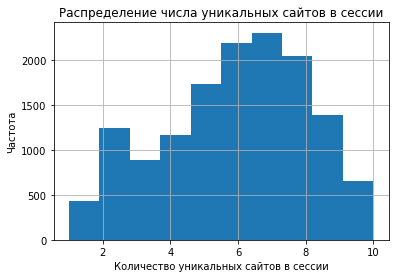
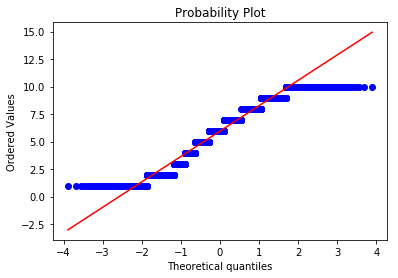
    Видны 'тяжелые' края у данного распределения, критерий Шапиро-Уилка отвергает гипотезу у нормальности распределения количества уникальных сайтов (p-value = 0.000).

С помощью биномиального критерия проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов, т.е. что доля случаев, когда пользователь повторно посетил какой-то сайт больше 95%.

Итого на уровне значимости a=0.05 с p-value=0.022  нулевая гипотеза о том, что доля случаев, когда пользователь повторно посетил какой-то сайт равна 95% отвергается. Доверительный интервал Уилсона для доли: (0.9501, 0.9570)

### Визуальный анализ данных

Для начала добавим в матрицу описания сессий еще такие признаки как продолжительность сессии, количество уникальных сайтов, час начала сессии, день недели начала сессии.
Для наглядности дадим пользователям имена в соответствии с их ID.

In [ ]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

matplotlib

Построим гистограмму распределения длины сессии в секундах ограниченную 200 секундами(тяжелый хвост).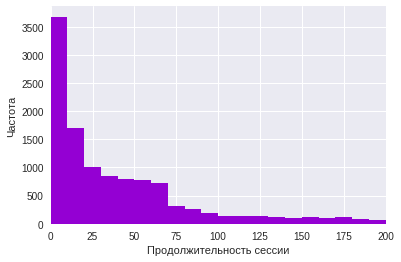


Построим гистограммы распределения числа уникальных сайтов в сессии для каждого из 10 пользователей по отдельности.
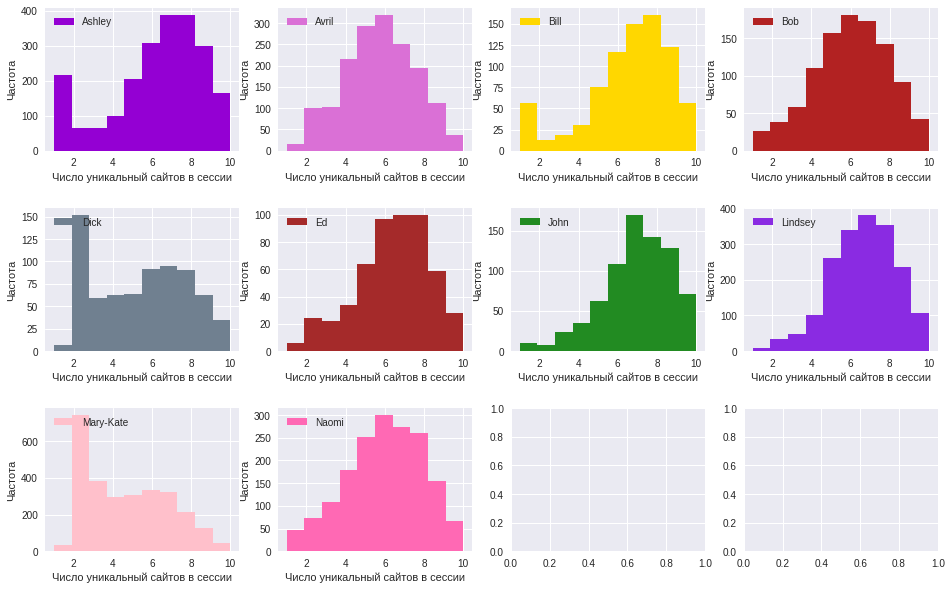

Как видно из графиков, за сессию пользователи из выборки посещают от 5 до 9 различных сайтов. При это выделяются пользователи Ashley, Bill, Dick и Mary-Kate, которые также часто проводят свои сессии в рамках 1-2 сайтов.


Построим гистограммы распределения часа начала сессии для каждого из 10 пользователей по отдельности. 
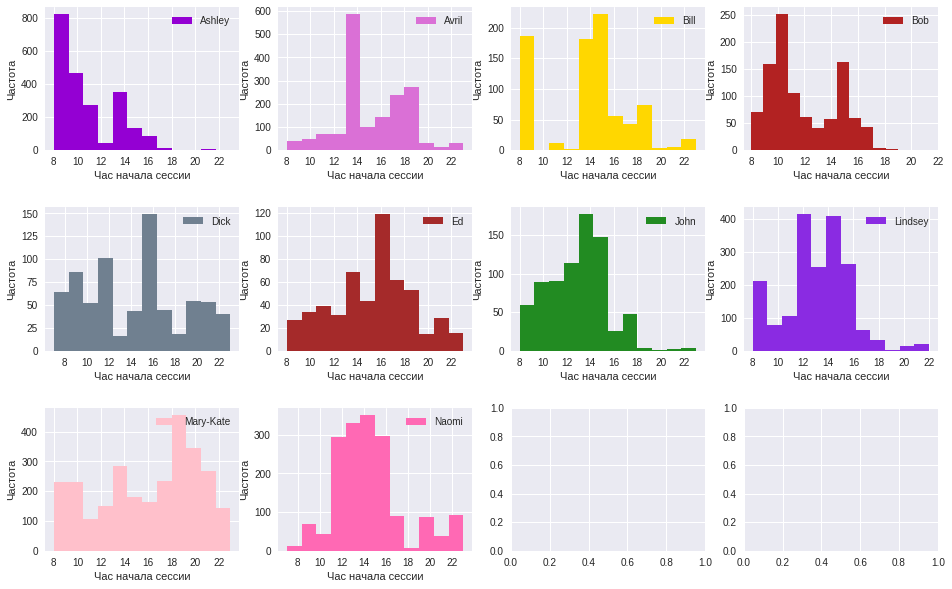

Сессии, в основном, начинаются в 8 утра и длятся до 8 вечера, при этом у таких пользователей как Ashley, Avril, Bill, Dick, Ed и Lindsey наблюдается заметный спад активности между 12 и 14 часами, это, возможно, связано с обедом. Пики активности соответственно приходятся на 12 и 16 часов Наиболее критический спад приходится на 18 часов, возможно связано с завершением рабочего дня. Особенно примечательные графики:
##### Avril
Резкий пик активности в 14 часов и такой же резкий спад, заставляет лишь гадать что происходит в это время.
##### Bill
Резкое, практически отсутствующая активность между 10 и 12 часами
##### Mary-Kate
В отличии от других пользователей, большая часть активности Mary-Kate приходится после 18 часов

Построим гистограмму распределения дня недели, в который началась сессия.
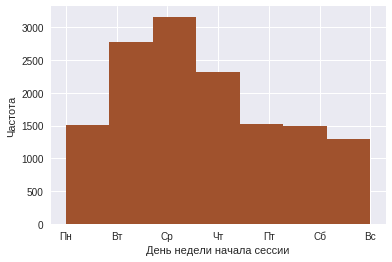

Построим график показывающий частоты посещений топ-10 сайтов.
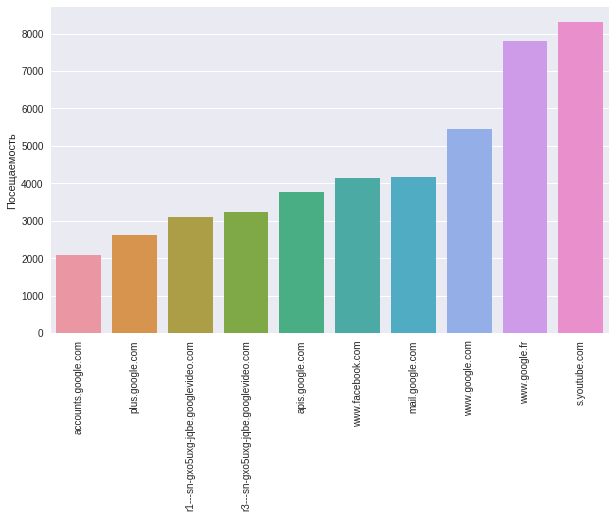

Выделим выходные дни признаком, добавим признак среднего времени проведенного пользователем на популярных топ 30 популярных сайтах за сессию и долю сайтов из топ 30 в сессии. Визуализация при помощи Plotly.

In [ ]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length = 10, windows_size = 10):    
    '''
    Преобразует из файлов с каждой строкой в формате "timestamp, посещенный веб-сайт" 
        матрицу с длиной сессии session_length.
    
    :param path_to_csv_files - путь к папке с файлами, каждое название файла в формате "user****.csv", 
        где **** - ID польователя.
    :param site_freq_path - путь к словарю частот сайтов в формате pickle
    :param session_length - длина одной сессии пользователя
    :param windows_size - размер скользящего окна

    :returns pandas.DataFrame - матрица сессий с новыми признаками
    '''
    files = sorted(glob(os.path.join(path_to_csv_files, '*.csv')))
    
    with open(site_freq_path, 'rb') as fin:
        fdict = pickle.load(fin)
        
    df_rows = []
    for file in tqdm_notebook(files):
        ind = int(os.path.basename(file)[4:8])
        dft = pd.read_csv(file, parse_dates=[0]) 
        for step in np.arange(dft.shape[0], step = windows_size):
            row = dft.iloc[step: step + session_length,:]
            tmin = row.timestamp.min()
            '''выделим субботу и воскресенье'''
            hday = 1 if tmin.dayofweek in [5, 6] else 0
            '''среднее время на популярных сайтах'''
            inds = list(map(lambda x: fdict[x][0], row.site))    
            p_time = [(row.timestamp.iloc[i+1] - row.timestamp.iloc[i]).total_seconds()
                      if (i+1) < len(row.timestamp) else 0
                      for i, ind in enumerate(inds) if ind in range(31)]
            session_timespan = (row.timestamp.max() - tmin).total_seconds()
            p_avg_time = sum(p_time) / max(session_timespan, 1)
            '''отношение количества популярных сайтов в сессии к общей продолжительности сессии'''
            pop_rate = float(len([0 for ind in inds if ind in range(31)]))/len(row)
            df_rows.append(
                np.hstack(( pop_rate, p_avg_time, hday, ind))
            )
    float_cols, int_cols = ['pop_rate',  'p_avg_time' ], [ 'hday', 'target']
     
    df = pd.DataFrame(df_rows, columns = float_cols + int_cols)
    for ic in int_cols:
        df[ic] = df[ic].astype(np.int32)
    
    return df

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [ ]:
import colorlover as cl

c = cl.scales['10']['div']['Spectral']

ls = []
for name, s_df in pd.groupby(nf_10users, 'target')['pop_rate']:
    prop = s_df.value_counts(normalize=True, sort=False, bins=10)
    ls.append(np.hstack((name, prop.values)))
tmp_df = pd.DataFrame(ls)

traces = [go.Bar(x = tmp_df.iloc[:,0],
                 y = tmp_df.iloc[:,i],
                 marker = dict(color=c[i-1]),
                 name = "({} - {}]".format((i-1)/10, i/10) )
          for i in range(1, 11)]

layout = go.Layout(
    barmode = 'stack',
    yaxis = {'title' : 'Доля популярных сайтов в сессии'},
    title = 'Распределение доли популярных сайтов в сессии пользователя'
)

fig = go.Figure(data = traces, layout = layout)
iplot(fig, show_link=False)

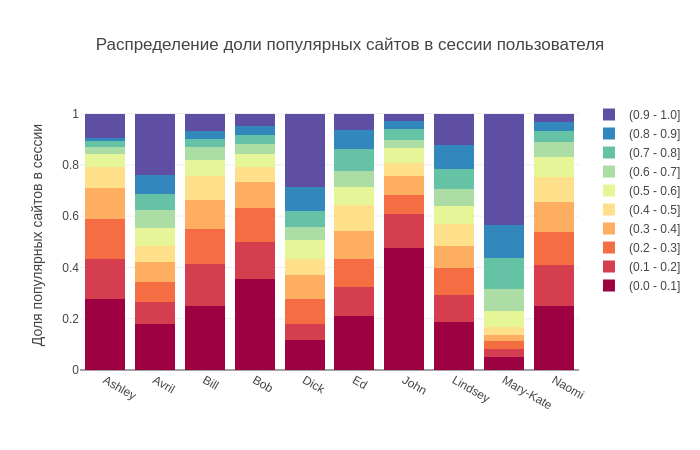

Пользователи, в основном, мало пользуются популярными сайтами, возможно потому, что наиболее популярные сайты являются медийными, а сессии пользователей приходятся на рабочее время, в которое им приходится пользоваться специализированными ресурсами. Особо интересны графики Ashley, Avril, Bill и Dick, они имеют резко выделяющуюся частотность доли равной 1, это показывает, что данные пользователи  иногда создают новые сессии только для того, чтобы воспользоваться популярными сайтами.
Также от всех отличается Mary-Kate, которая и вовсе предпочитает, практически только популярные сайты.

In [ ]:
from plotly import tools

fig = tools.make_subplots(rows=3, cols=4, subplot_titles = np.unique(nf_10users.target),
                         specs=[[{}, {}, {},  {}], 
                                [{}, {}, {},  {}], 
                                [{'colspan': 2}, None, {'colspan': 2}, None]])

for idx, (user, sub_df) in  enumerate(pd.groupby(nf_10users, 'target')): 
    y, x = int(idx / 4) + 1, int( idx % 4 ) + 1
    trace = go.Histogram(x=sub_df['p_avg_time'], name=user)
    if x==2 and y==3:
        x=3
    fig.append_trace(trace, y, x)
    fig['layout']['xaxis{}'.format(idx+1)].update(tickvals=np.arange(11)/10)

fig['layout'].update(height=600, width=950, title='Доля времени на популярных сайтах', showlegend=False)
iplot(fig, show_link=False)

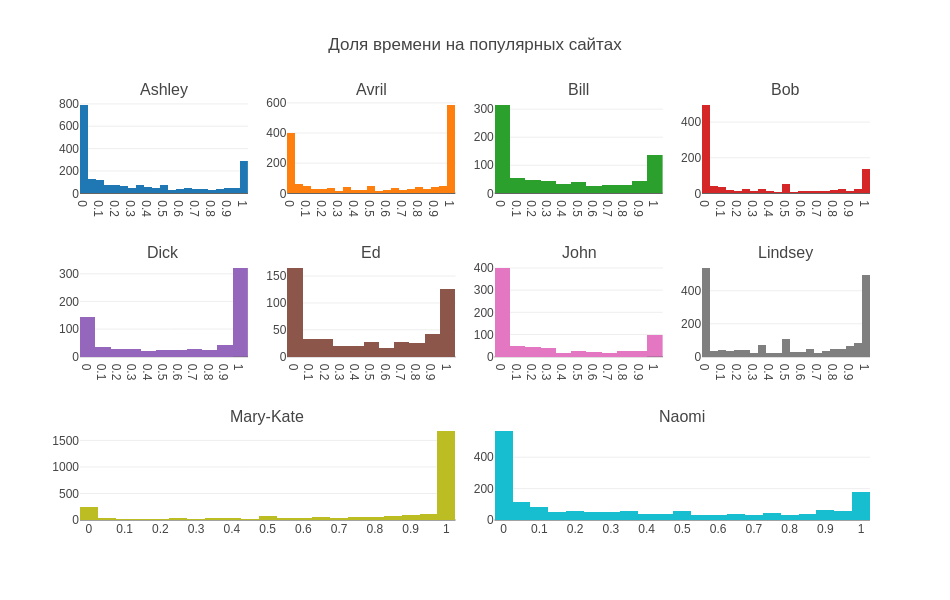
Данный график интересен тем, что показывает характер сессий пользователя. Отчетливо видно, что на каждом графике видны две моды(0 и 1) это говорит о том, что каждый пользователь иногда создает сессии для захода именно на популярные сайты, а бывает, что вообще не заходит на них, а заходит на специфические сайты(видимо по работе?).
При этом выделяется пользователь Mary-Kate сессий которого практически полностью проходят на популярных сайтах(тоже говорил и предыдущий график). Однако большую пользу может привести приведение данного признака к булевому типу (больше ли доля чем 0.5).

In [ ]:
data =  nf_10users.groupby('target', as_index = False).hday.mean()

traces = go.Bar(x = data.target, 
                y = data.hday,
                marker = dict(color=c))
          
layout = go.Layout(yaxis=dict(title='Доля сессий в выходные дни'))

fig = go.Figure(data=[traces], layout=layout )
iplot(fig, show_link = False)

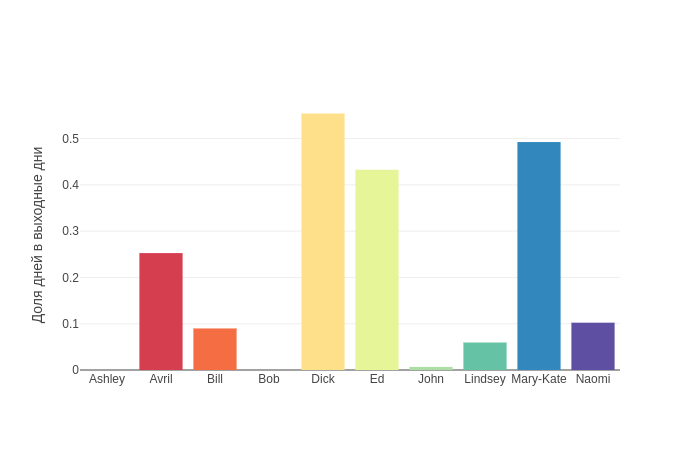
На графиках отчетливо заметно различие между активностью в выходные дни у пользователей. Есть пользователи, у которых полностью отсутствует активность в выходные (Ashley, Bob, John), также, у которых активность высока (Avril, Dick, Ed, Mary-Kate). Думаю, это связано с различными методами провождения свободного времени и отдыха.

### Сравнение алгоритмов классификации

Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации. Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости. Используется методы и классы из библиотеки scikit-learn.

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

Вспомогательная функция для отрисовки кривых валидации.

In [ ]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

Обучим несколько алгоритмов на наших признакахи и сравним их.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
forest.fit(X_train, y_train)
valid = accuracy_score(y_valid, forest.predict(X_valid))

Точность случайного леса на нашей выборке составила: 0.7312

Обучим svm классификатор

In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1, random_state=17)
svm_cvs = cross_val_score(svm, cv=skf, n_jobs=-1, X = X_train, y = y_train)

Точность svm классификатора на кросс-валидации: 0.7769

Подберем параметр С  в диапазоне (1e-3, 1) используя GridSearchCV

In [ ]:
svm_params = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher = GridSearchCV(svm, svm_params, scoring='accuracy', n_jobs=-1, cv=skf)
svm_grid_searcher.fit(X_train, y_train)

accuracy: 0.764986791303
best_params: {'C': 0.24213793103448275}

на валидации: 0.783598009007

Нарисуем график зависимости доли правильных ответов на кросс-валидации от C
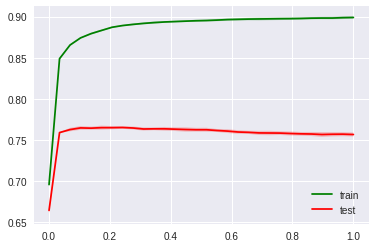

Применим данную модель для разной длины сессии и размера окна.

In [ ]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(os.path.join(PATH_TO_DATA, path_to_X_pickle), 'rb') as X_sparse:
        X_sparse = pickle.load(X_sparse)
    with open(os.path.join(PATH_TO_DATA, path_to_y_pickle), 'rb') as y:
        y = pickle.load(y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                          test_size=test_size, 
                                                          random_state=random_state, stratify=y)
    train_cv_score = cross_val_score(estimator, cv=cv, n_jobs=-1, 
                                     scoring='accuracy', X=X_train, y=y_train).mean()
    estimator.fit(X_train, y_train)
    test_cv_score = accuracy_score(y_valid,  estimator.predict(X_valid))
    
    return train_cv_score, test_cv_score 

In [ ]:
estimator = svm_grid_searcher.best_estimator_

for window_size, session_length in tqdm_notebook(itertools.product([10, 7, 5], [15, 10, 7, 5])):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, 
                                                                                         window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, 
                                                                                         window_size))
        print(window_size, session_length)
        print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv = skf))

Полученные результаты:
#### 10 15
(0.82412334030111822, 0.84166864185826029)
#### 10 10
(0.76498658317429324, 0.78359800900687371)
#### 7 15
(0.8504951547307148, 0.85564957690393229)
#### 7 10
(0.79992559213440051, 0.80736684917869583)
#### 7 7
(0.75156145420704468, 0.76339804214368678)
#### 5 15
(0.87155898858602077, 0.8771929824561403)
#### 5 10
(0.81836230505824814, 0.8285917496443812)
#### 5 7
(0.77304177154740927, 0.78828828828828834)
#### 5 5
(0.72457100088188031, 0.73779042200094835)

Как видно размер окна 5 и длина сессии 15 показывают наилучшие результаты.

Данную задачу многоклассовой классификации можно свести к одноклассовой, к примеру идентифицировать определенного пользователя среди остальных. Была построена логистическая регрессия для такой задачи и построена кривая обучения.
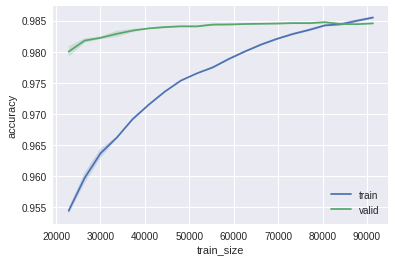
Результаты кажутся впечатляющими, но в таких данных присутствует дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Соответственно более обоснованным в такой постановке задачи использовать точность, полноту, f1 меру, pr auc, roc auc или другие меры на которые влияет баланс классов.

В дальнейшем использование roc_auc метрики и стекинга приблизило значение roc_auc на валидации до 0.988, что является относительно хорошим показателем в задачах классификации. Еще одним хорошим дополнение стало использование tf-idf над сайтами, что также привело к увеличению целевой метрики.

Исходя из проделанной работы видно, что используя лишь сведенья о времени захода и просмотренном сайте можно с сравнительно большой точностью классифицировать пользователя, также это можно использовать для обнаружение аномалий в поведении пользователя и возможной поимки злоумышленников. Данный подход обобщается на разные сферы деятельности человека, поскольку вместо сайтов можно использовать другие последовательности операций которые делает человек.

Бухта Дмитрий, 2017